# 04 Results Analysis 

- Based on collected history and statistics gathered during training of hyperparameter tests and training of full classifiers

- Visualize training results and compare experiments

In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Paths
EXPERIMENTS_DIR = Path('../outputs/experiments')
FINAL_DIR = Path('../outputs/final')
FINAL_RESNET_DIR = Path('../outputs/final_resnet18')

## Load Experiment Results

In [3]:
# Find the results file (there should be one from run_experiments.py)
results_files = list(EXPERIMENTS_DIR.glob('full_results_*.json'))
print(f"Found {len(results_files)} experiment result files")

# Load the most recent one
if results_files:
    results_file = sorted(results_files)[-1]
    print(f"Loading: {results_file.name}")
    
    with open(results_file) as f:
        experiments = json.load(f)
    
    print(f"Loaded {len(experiments)} experiments")
else:
    print("No experiment results found!")
    experiments = []

Found 1 experiment result files
Loading: full_results_20260201_210200.json
Loaded 32 experiments


In [4]:
# Convert to DataFrame for easier analysis
if experiments:
    df = pd.DataFrame([{
        'name': exp['name'],
        'learning_rate': exp['config']['learning_rate'],
        'scheduler': exp['config']['scheduler'] or 'none',
        'augmentation': exp['config']['augmentation'],
        'best_val_acc': exp['best_val_acc'],
        'epochs_trained': exp['epochs_trained'],
        'train_time': exp['train_time_seconds'] / 60,  # minutes
    } for exp in experiments])
    
    # Sort by accuracy
    df = df.sort_values('best_val_acc', ascending=False)
    print("Top 10 experiments:")
    print(df.head(10).to_string(index=False))

Top 10 experiments:
                     name  learning_rate scheduler augmentation  best_val_acc  epochs_trained  train_time
    lr0.0001_cosine_light         0.0001    cosine        light      0.989571              11    3.793333
   lr0.0001_nosched_heavy         0.0001      none        heavy      0.989170              11    3.800000
     lr0.0001_cosine_none         0.0001    cosine         none      0.989170               9    3.141667
lr0.0001_nosched_moderate         0.0001      none     moderate      0.989170              10    3.478333
   lr0.0001_nosched_light         0.0001      none        light      0.988769               8    2.815000
    lr0.0001_cosine_heavy         0.0001    cosine        heavy      0.988367              12    4.238333
 lr0.0001_cosine_moderate         0.0001    cosine     moderate      0.986763               8    2.831667
    lr0.0005_cosine_heavy         0.0005    cosine        heavy      0.986362              20    6.876667
 lr0.0005_cosine_moderate 

## Hyperparameter Analysis

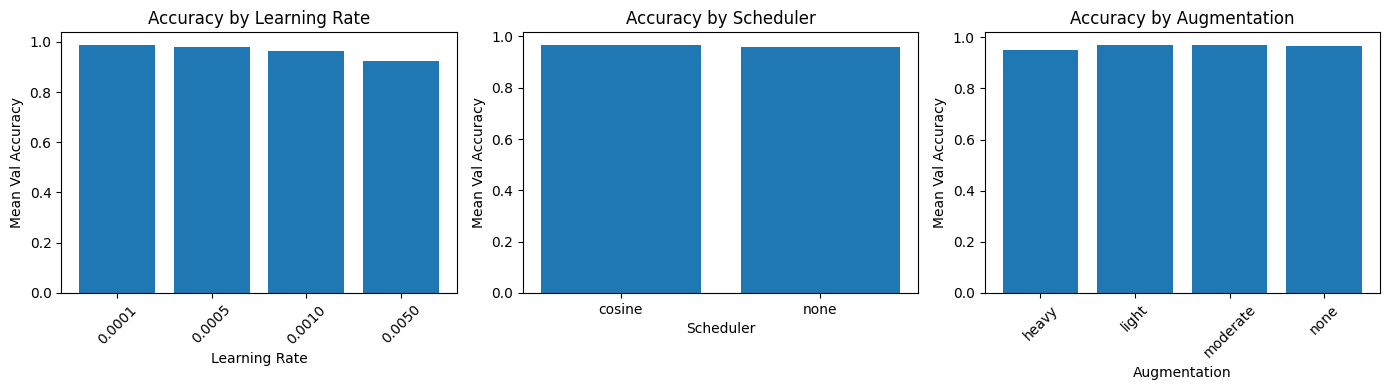

In [5]:
# Accuracy by learning rate
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# By learning rate
lr_stats = df.groupby('learning_rate')['best_val_acc'].mean()
axes[0].bar(range(len(lr_stats)), lr_stats.values)
axes[0].set_xticks(range(len(lr_stats)))
axes[0].set_xticklabels([f'{lr:.4f}' for lr in lr_stats.index], rotation=45)
axes[0].set_ylabel('Mean Val Accuracy')
axes[0].set_xlabel('Learning Rate')
axes[0].set_title('Accuracy by Learning Rate')

# By scheduler
sched_stats = df.groupby('scheduler')['best_val_acc'].mean()
axes[1].bar(range(len(sched_stats)), sched_stats.values)
axes[1].set_xticks(range(len(sched_stats)))
axes[1].set_xticklabels(sched_stats.index)
axes[1].set_ylabel('Mean Val Accuracy')
axes[1].set_xlabel('Scheduler')
axes[1].set_title('Accuracy by Scheduler')

# By augmentation
aug_stats = df.groupby('augmentation')['best_val_acc'].mean()
axes[2].bar(range(len(aug_stats)), aug_stats.values)
axes[2].set_xticks(range(len(aug_stats)))
axes[2].set_xticklabels(aug_stats.index, rotation=45)
axes[2].set_ylabel('Mean Val Accuracy')
axes[2].set_xlabel('Augmentation')
axes[2].set_title('Accuracy by Augmentation')

plt.tight_layout()
plt.savefig('../outputs/experiments/hyperparameter_comparison.png', dpi=150)
plt.show()

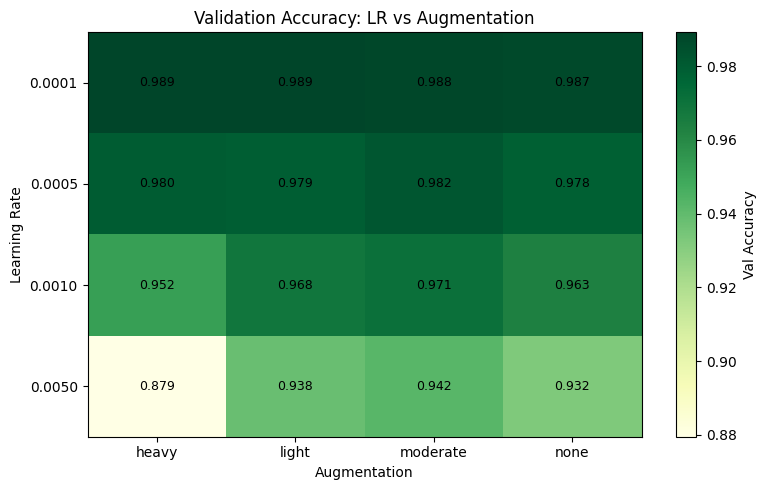

In [6]:
# Heatmap: Learning rate vs Augmentation
pivot = df.pivot_table(values='best_val_acc', index='learning_rate', columns='augmentation', aggfunc='mean')

fig, ax = plt.subplots(figsize=(8, 5))
im = ax.imshow(pivot.values, cmap='YlGn', aspect='auto')

ax.set_xticks(range(len(pivot.columns)))
ax.set_xticklabels(pivot.columns)
ax.set_yticks(range(len(pivot.index)))
ax.set_yticklabels([f'{lr:.4f}' for lr in pivot.index])
ax.set_xlabel('Augmentation')
ax.set_ylabel('Learning Rate')
ax.set_title('Validation Accuracy: LR vs Augmentation')

# Add values to cells
for i in range(len(pivot.index)):
    for j in range(len(pivot.columns)):
        val = pivot.values[i, j]
        ax.text(j, i, f'{val:.3f}', ha='center', va='center', fontsize=9)

plt.colorbar(im, ax=ax, label='Val Accuracy')
plt.tight_layout()
plt.savefig('../outputs/experiments/lr_aug_heatmap.png', dpi=150)
plt.show()

## Best Experiment Training Curves

Best experiment: lr0.0001_cosine_light
Val accuracy: 0.9896


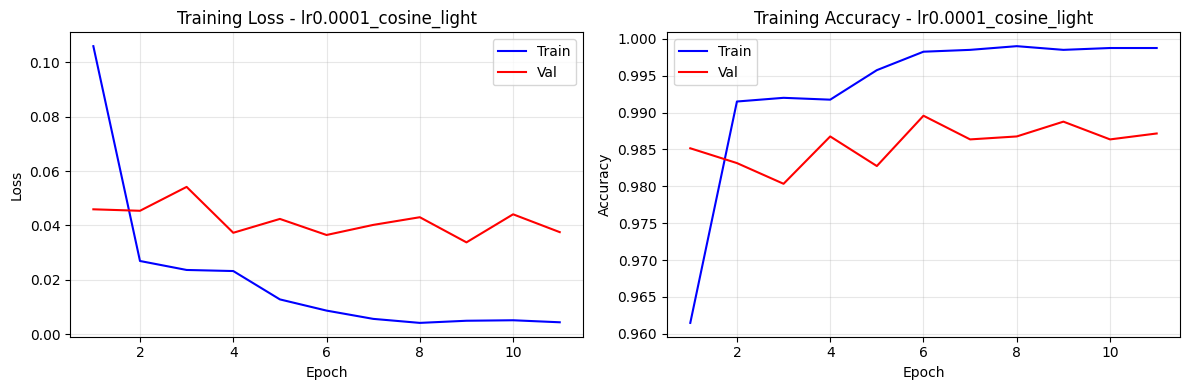

In [7]:
# Find best experiment
best_exp = max(experiments, key=lambda x: x['best_val_acc'])
print(f"Best experiment: {best_exp['name']}")
print(f"Val accuracy: {best_exp['best_val_acc']:.4f}")

history = best_exp['history']
epochs = range(1, len(history['train_loss']) + 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss
axes[0].plot(epochs, history['train_loss'], 'b-', label='Train')
axes[0].plot(epochs, history['val_loss'], 'r-', label='Val')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title(f"Training Loss - {best_exp['name']}")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(epochs, history['train_acc'], 'b-', label='Train')
axes[1].plot(epochs, history['val_acc'], 'r-', label='Val')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title(f"Training Accuracy - {best_exp['name']}")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/experiments/best_experiment_curves.png', dpi=150)
plt.show()

## Final Model Results

In [9]:
# Load final training results
def load_final_results(path):
    if path.exists():
        with open(path) as f:
            return json.load(f)
    return None

mobilenet_results = load_final_results(FINAL_DIR / 'final_training_results.json')
resnet_results = load_final_results(FINAL_RESNET_DIR / 'final_training_results.json')

print("MobileNetV2 Final:")
if mobilenet_results:
    r = mobilenet_results['results']
    print(f"  Val Acc: {r['best_val_acc']:.4f}")
    print(f"  F1: {r['f1']:.4f}")
    print(f"  Epochs: {r['epochs_trained']}")
    print(f"  Time: {r['train_time_minutes']:.1f} min")

print("\nResNet18 Final:")
if resnet_results:
    r = resnet_results['results']
    print(f"  Val Acc: {r['best_val_acc']:.4f}")
    print(f"  F1: {r['f1']:.4f}")
    print(f"  Epochs: {r['epochs_trained']}")
    print(f"  Time: {r['train_time_minutes']:.1f} min")

MobileNetV2 Final:
  Val Acc: 0.9920
  F1: 0.9920
  Epochs: 15
  Time: 21.2 min

ResNet18 Final:
  Val Acc: 0.9900
  F1: 0.9899
  Epochs: 10
  Time: 12.0 min


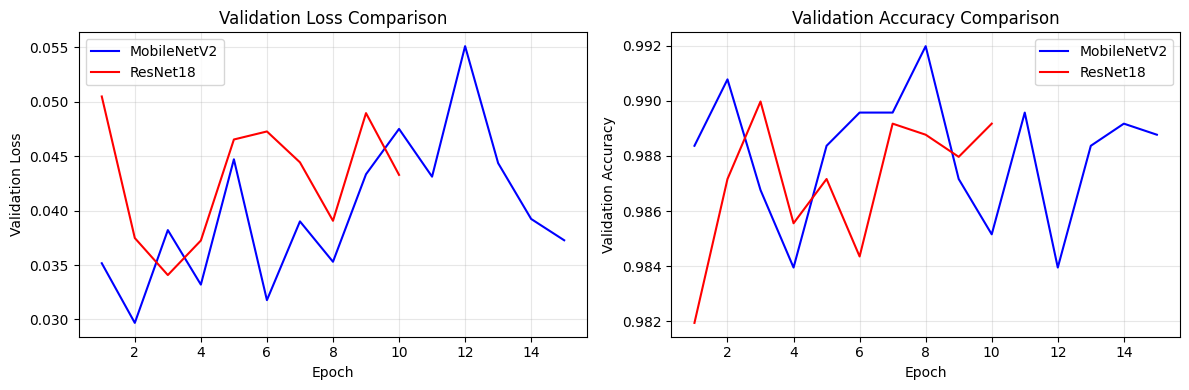

In [10]:
# Compare training curves: MobileNetV2 vs ResNet18
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

if mobilenet_results and resnet_results:
    mob_hist = mobilenet_results['history']
    res_hist = resnet_results['history']
    
    mob_epochs = range(1, len(mob_hist['train_loss']) + 1)
    res_epochs = range(1, len(res_hist['train_loss']) + 1)
    
    # Loss comparison
    axes[0].plot(mob_epochs, mob_hist['val_loss'], 'b-', label='MobileNetV2')
    axes[0].plot(res_epochs, res_hist['val_loss'], 'r-', label='ResNet18')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Validation Loss')
    axes[0].set_title('Validation Loss Comparison')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy comparison
    axes[1].plot(mob_epochs, mob_hist['val_acc'], 'b-', label='MobileNetV2')
    axes[1].plot(res_epochs, res_hist['val_acc'], 'r-', label='ResNet18')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Validation Accuracy')
    axes[1].set_title('Validation Accuracy Comparison')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../outputs/final/model_comparison.png', dpi=150)
    plt.show()
else:
    print("Missing results for comparison")

## Summary Table

In [11]:
# Create summary table for report
summary_data = []

if mobilenet_results:
    r = mobilenet_results['results']
    summary_data.append({
        'Model': 'MobileNetV2',
        'Parameters': '2.2M',
        'Val Accuracy': f"{r['best_val_acc']:.4f}",
        'Precision': f"{r['precision']:.4f}",
        'Recall': f"{r['recall']:.4f}",
        'F1': f"{r['f1']:.4f}",
        'Epochs': r['epochs_trained'],
        'Time (min)': r['train_time_minutes'],
    })

if resnet_results:
    r = resnet_results['results']
    summary_data.append({
        'Model': 'ResNet18',
        'Parameters': '11.1M',
        'Val Accuracy': f"{r['best_val_acc']:.4f}",
        'Precision': f"{r['precision']:.4f}",
        'Recall': f"{r['recall']:.4f}",
        'F1': f"{r['f1']:.4f}",
        'Epochs': r['epochs_trained'],
        'Time (min)': r['train_time_minutes'],
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

      Model Parameters Val Accuracy Precision Recall     F1  Epochs  Time (min)
MobileNetV2       2.2M       0.9920    0.9944 0.9896 0.9920      15       21.24
   ResNet18      11.1M       0.9900    0.9935 0.9864 0.9899      10       12.04


## Key Findings

**Hyperparameter Search (32 experiments):**
- Best learning rate: 0.0001
- Best scheduler: cosine annealing
- Best augmentation: light (horizontal flip only)
- More aggressive augmentation didn't help for this dataset

**Final Models:**
- MobileNetV2 achieved 99.20% validation accuracy with only 2.2M parameters
- ResNet18 achieved 99.00% with 11.1M parameters (5x more)
- Smaller model performed slightly better - likely because hyperparameters were tuned for it
- Both models train quickly (~12-21 min) with early stopping

**Conclusion:**
MobileNetV2 with light augmentation and cosine LR scheduler is the best choice for this task.